# Imputation stability

We explore various expectile imputation strategies and their stability through repeated imputation.

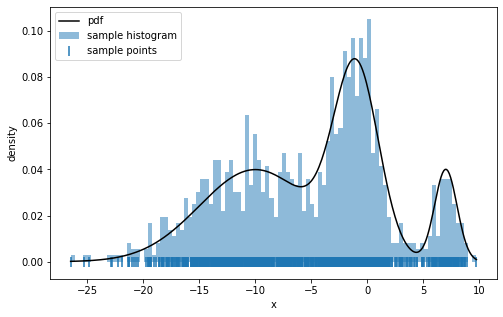

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
import scipy.optimize as opt

import tqdm.notebook as tqdm

from util.expectiles import expectile
from util.gmm import EXAMPLE

SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000, figsize=(8, 5))

## Helper functions

In [18]:
def tauspace(k):
    """
    Return k evenly spaced floats between 0 and 1 (not inclusive),
    with the (k//2)th equal to 0.5. k must be odd.
    """
    if not k % 2: raise ValueError("k must be odd.")
    e = 1/(2*k)
    return np.linspace(e, 1-e, k)

def exp_smooth(x, y, newx=None, ω=1):
    """
    Given x, y(x), compute y_s(newx), smoothed version, with bandwidth ω
    """
    if newx is None: newx=x
    W = np.exp(-np.square(newx[:, np.newaxis] - x)/ω)
    W /= W.sum(axis=-1, keepdims=True)
    return W @ y

def polyfit(x, y, d, **kwargs):
    return np.polynomial.polynomial.Polynomial.fit(x, y, d, **kwargs)

def polyinv(p, y, tol=1e-6, domain=None):
    if np.isscalar(y):
        y = [y]
        n = 1
    else:
        n = len(y)
    x = np.zeros(n)
    for i in range(n):
        xi = (p - y[i]).roots()
        xi = xi[np.abs(xi.imag) < tol].real
        if domain:
            xi = xi[domain[0] < xi]
            xi = xi[xi < domain[1]]
        x[i] = xi[:1]
    return x

def lerp(x0, y0, y):
    """
    Return x in (increasing) x0 corresponding to y in (increasing) y0
    using linear interpolation (or nan for out-of-range values)
    """
    n = len(y0)
    x = np.zeros_like(y, dtype=float)
    i = np.searchsorted(y0, y)
    out = (i == 0) | (i == n)

    ok = ~out
    i = i[ok]
    y_lo = y0[i-1]
    y_hi = y0[i]
    x_lo = x0[i-1]
    x_hi = x0[i]
    t = (y[ok] - y_lo)/(y_hi - y_lo)
    x[out] = np.nan
    x[ok] = (1-t)*x_lo + t*x_hi
    return x

## Imputers

In [19]:
class NaiveImputer:
    def fit(self, ε, τ):
        self.x = ε
        return self
    def sample(self, k):
        return np.random.choice(self.x, k)
    def __repr__(self):
        return f"NaiveImputer()"

In [20]:
class OptBasedImputer:
    def __init__(self, method='root', start='bestof1000', use_lrm=False, verbose=False):
        self.method = method
        self.start = start
        self.use_lrm = use_lrm
        self.verbose = verbose
    def fit(self, ε, τ):
        self.τ = τ
        self.ε = ε
        if self.use_lrm:
            self.lrm = np.sqrt(τ / (1-τ))
        else:
            self.lrm = 1
        return self
    def sample(self, k):
        # initialise
        if self.verbose: print("initialising...")
        lo, hi = self.ε.min(), self.ε.max()
#         lo, hi = 1.5*lo - 0.5*hi, 1.5*hi - 0.5*lo # expand initialisation to help optimiser?
        if self.start == 'uniform':
            # initialise as uniform distribution between most extreme expectiles
            z0 = np.linspace(lo, hi, k)
        elif self.start == 'bestof1000':
            # this is implemented for 2020 paper to 'significantly improve optimum found'
            # (note: they also repeat this 10 times)
            zs = np.random.uniform(lo, hi, (1000, k))
            z0 = zs[np.argmin(self._ER_loss(zs))]
        # optimise
        if self.verbose: print("optimising...")
        if self.method=='root':
            if k != len(self.ε):
                raise Exception("Hey! This method requires n=k (number of expectiles)")
            x = opt.root(self._grad_ε_ER_loss, x0=z0).x
        elif self.method=='min':
            # this method is much slower...
            def sum_square_grads(sample):
                return np.sum(self._grad_ε_ER_loss(sample)**2)
            x = opt.minimize(sum_square_grads, x0=z0).x
        return x
    def _ER_loss(self, X):
        n      = X.shape[-1]
        rpe    = X[..., np.newaxis] - self.ε
        scale  = np.abs((rpe < 0) - self.τ)
        losses = np.sum(scale * self.lrm * np.square(rpe) / n, axis=-2)
        return np.sum(losses, axis=-1)
    def _grad_ε_ER_loss(self, X):
        n     = X.size
        rpe   = X[:, np.newaxis] - self.ε  # rpe[i, k] = X[i] - ε[k]
        scale = np.abs((rpe < 0) - self.τ) # scale[i, k] = τ[k] if rpe[i, k] > 0 else 1 - τ[k]
        grads = 2 * np.sum(scale * self.lrm * rpe, axis=0) / n
        return grads
    def __repr__(self):
        return f"OptBasedImputer({self.method=}, {self.start=})"

In [21]:
class DirectImputer:
    def __init__(self, smooth_invert=False, exp_tails=False):
        self.smooth_invert = smooth_invert
        self.exp_tails = exp_tails
    def fit(self, ε_, τ_, i=None):
        g_ = np.gradient(ε_, τ_, edge_order=2)
        if i is None: i = ε_.size//2
        self.μ = μ = ε_[i]
        self.ε = ε = np.delete(ε_, i)
        self.τ = τ = np.delete(τ_, i)
        self.g = g = np.delete(g_, i)
        self.N = N = -(ε - μ + τ * g * (1-2*τ))
        self.D = D = g * (1-2*τ)**2
        self.F = F = N / D
        self.f = np.gradient(F, ε, edge_order=1)
        return self
    def sample(self, k):
        y = np.random.random(k)
        if self.smooth_invert:
            x = exp_smooth(self.F, self.ε, y, ω=1/self.ε.size**2)
        else:
            i = np.searchsorted(self.F, y)
            x = self.ε[np.clip(i, 0, self.ε.size-1)]
        if self.exp_tails:
            lo = np.where(y <  self.F.min())
            x[lo] = self.ε.min() - np.random.exponential(size=len(lo[0]))
            hi = np.where(y >= self.F.max())
            x[hi] = self.ε.max() + np.random.exponential(size=len(hi[0]))
        return x
    def __repr__(self):
        return f"DirectImputer({self.smooth_invert=}, {self.exp_tails=})"

In [36]:
class InterpolatingImputer:
    def fit(self, ε_, τ_, i=None):
        # find CDF for interpolation
        g_ = np.gradient(ε_, τ_, edge_order=2)
        if i is None: i = ε_.size//2
        self.μ = μ = ε_[i]
        self.ε = ε = np.delete(ε_, i)
        self.τ = τ = np.delete(τ_, i)
        self.g = g = np.delete(g_, i)
        self.N = N = -(ε - μ + τ * g * (1-2*τ))
        self.D = D = g * (1-2*τ)**2
        self.F = F = N / D
        self.f = np.gradient(F, ε, edge_order=1)
        # then a linear fit for extrapolation
        self.p = polyfit(ε, sc.logit(F), 1, domain=[-1,1],window=[-1,1])
        self.b, self.a = self.p
        return self
    def F_inv(self, y):
        x = lerp(self.ε, self.F, y)
        out = np.isnan(x)
        x[out] = (sc.logit(y[out])-self.b)/self.a
        return x
    def sample(self, k):
        y = np.random.random(k)
        x = self.F_inv(y)
        return x
    def __repr__(self):
        return f"InterpolatingImputer()"

In [23]:
class PolyLogitInterpImputer:
    def __init__(self, x=np.linspace(-25, 10, 2000), degree=3):
        self.degree = degree
        self.x = x
    def fit(self, ε_, τ_, i=None):
        self.ε_ = ε_
        self.τ_ = τ_
        self.ε = ε = x = self.x
        self.p = p = polyfit(ε_, sc.logit(τ_), self.degree)
        self.μ = μ = polyinv(p, sc.logit(0.5))
        self.τ = τ = sc.expit(p(ε))
        self.g = g = np.gradient(ε, τ, edge_order=2)
        self.N = N = -(ε - μ + τ*g*(1-2*τ))
        self.D = D = g * (1-2*τ)**2
        self.F = F = N / D
        self.f = f = np.gradient(F, ε, edge_order=1)
        return self
    def sample(self, k):
        y = np.random.random(k)
        i = np.searchsorted(self.F, y)
        x = self.ε[np.clip(i, 0, self.ε.size-1)]
        return x
    def __repr__(self):
        return f"PolyLogitInterpImputer({self.degree=})"

In [24]:
class PolyLogitImputer:
    def __init__(self, degree=3, i=None):
        self.degree = degree
    def fit(self, ε_, τ_):
        self.ε_  = ε_
        self.τ_  = τ_
        self.p   = polyfit(ε_, sc.logit(τ_), self.degree)
        self.dp  = self.p.deriv()
        self.ddp = self.dp.deriv()
        self.μ   = polyinv(self.p, sc.logit(0.5))
        return self
    def F(self, x):
        μ   = self.μ        # ε(0.5)
        px  = self.p(x)     # p(x)
        dpx = self.dp(x)    # p'(x)
        spx = sc.expit(px)  # σ(p(x))
        tpx = (1-2*spx)     # tanh(p(x)) = 1-2σ(p(x))
        return -spx/tpx*(1 + (x-μ)*(1-spx)*dpx/tpx)
    def f(self, x):
        xμ   = x - self.μ         # x - μ
        px   = self.p(x)          # p(x)
        dpx  = self.dp(x)         # p'(x)
        ddpx = self.ddp(x)        # p''(x)
        sx   = sc.expit(px)       # τ(x) = σ(p(x))
        tx   = (1-2*sx)           # 1-2τ(x) = tanh(p(x))
        dsx  = sx*(1-sx)*dpx      # τ'(x) = σ(p(x))(1-σ(p(x)))p'(x)
        fx = -dsx*(xμ*dpx*tx + xμ*ddpx/dpx + 2 + 4*xμ*dsx/tx)/(tx**2)
        return fx
    def τ(self, x):
        return sc.expit(self.p(x))
    def ε(self, y):
        return polyinv(self.p, sc.logit(y))
    def sample(self, k):
        y = np.random.random(k)
        x = opt.root(lambda x: self.F(x)-y, x0=np.zeros(k), jac=lambda x: np.diag(self.f(x))).x
        return x
    def __repr__(self):
        return f"PolyLogitImputer(d={self.degree})"

## Stability experiments

In [47]:
def shift_experiment(taus, imputer, sample=SAMPLE, n_iterations=100, n_samples=None,
                     cm=plt.cm.gist_rainbow, bins=None, **kwargs):
    if n_samples is None: n_samples = len(sample)
    print("imputation shift experiment with", imputer)
    print("n samples:    ", n_samples)
    print("n iterations: ", n_iterations)
    # record more expectiles than those provided
    full_taus = tauspace(999)
    expectiles = np.ndarray((n_iterations+1, 999))
    samples = np.ndarray((n_iterations, n_samples))
    sample0 = sample
    # perform experiment:
    expectiles[0] = expectile(sample, full_taus)
    for i in tqdm.trange(1, n_iterations+1):
        imputer.fit(expectile(sample, taus), taus, **kwargs)
        sample = imputer.sample(n_samples)
        expectiles[i] = expectile(sample, full_taus)
        samples[i-1] = sample
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.set_xlabel("asymmetry (τ)")
    ax1.set_ylabel("expectile (ε)")
    ax2.set_xlabel("sample point")
    ax2.set_ylabel("sample density")
    # visualise:
    if bins is None: bins=np.linspace(samples.min(), samples.max(), 100)
    for i in reversed(range(0, n_iterations+1, max(1, n_iterations//5))):
        ax1.plot(full_taus, expectiles[i],
                 label=f'after {i} iterations', color=cm(i/n_iterations))
        ax2.hist(samples[i-1] if i else sample0,
                 density=True, alpha=0.5, bins=bins,
                 label=f'after {i} iterations', color=cm(i/n_iterations))
    ax1.legend()
    ax2.legend()
    plt.show()
    fig, ax3 = plt.subplots(1, 1, figsize=(14, 5))
    ax3.set_xlabel("number of iterations")
    ax3.set_ylabel("expectile (ε)")
    for i in [0, 99, 199, 299, 399, 499, 599, 699, 799, 899, 998]:
        ax3.plot(expectiles[:, i], marker='x', color=cm(i/999), label=f'τ={full_taus[i]:.4f}')
    plt.legend(loc=(1.01, 0.1))
    plt.show()

### Deepmind's Naive imputer

imputation shift experiment with NaiveImputer()
n samples:     1000
n iterations:  20


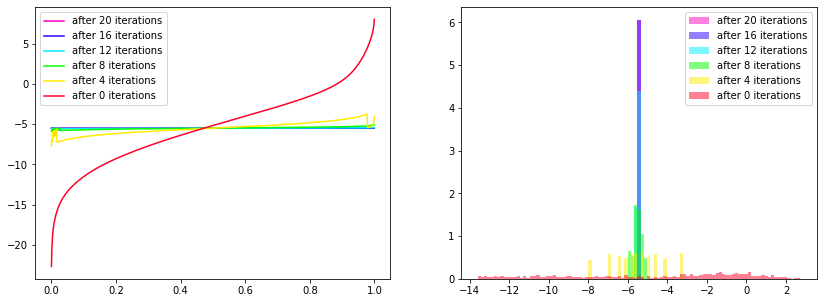

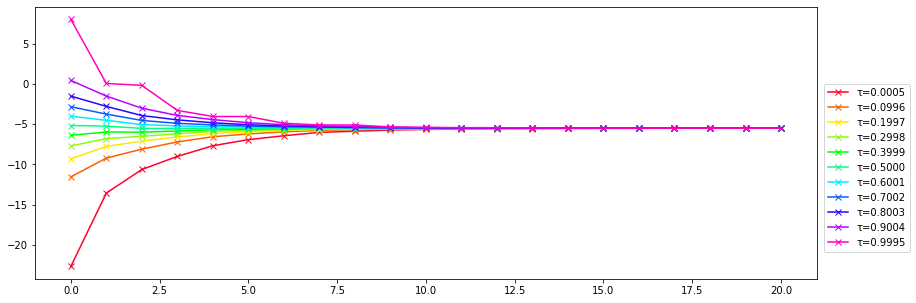

imputation shift experiment with NaiveImputer()
n samples:     1000
n iterations:  20


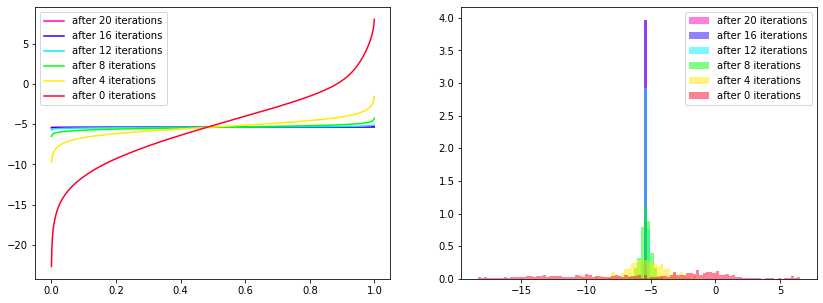

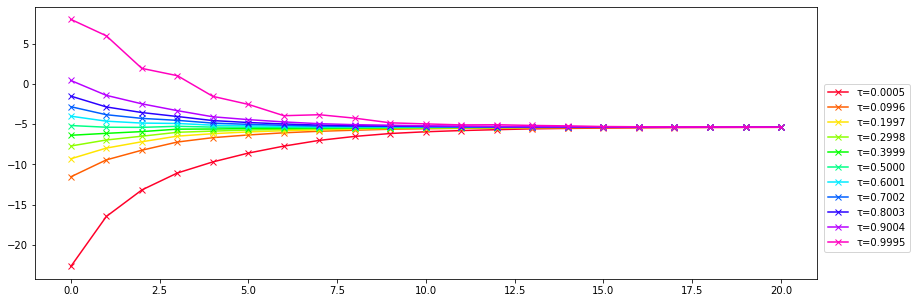

imputation shift experiment with NaiveImputer()
n samples:     1000
n iterations:  20


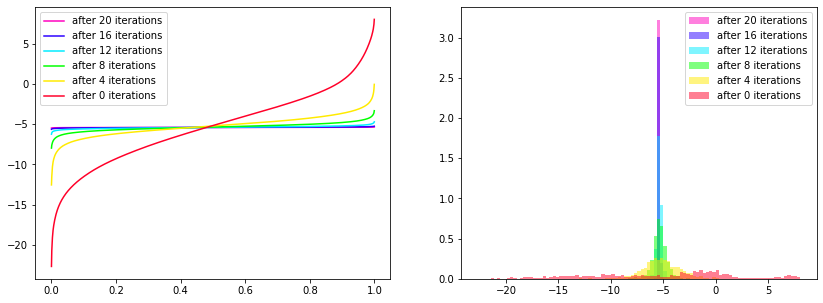

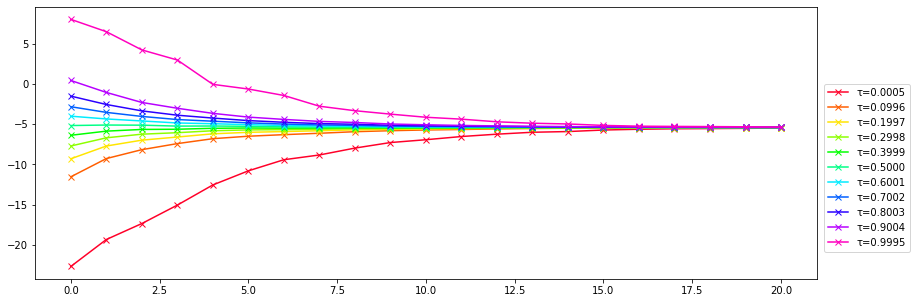

In [28]:
shift_experiment(tauspace(11), NaiveImputer(), n_iterations=20)
shift_experiment(tauspace(101), NaiveImputer(), n_iterations=20)
shift_experiment(tauspace(1001), NaiveImputer(), n_iterations=20)

### Deepmind's Optimisation-based imputer

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     101
n iterations:  20


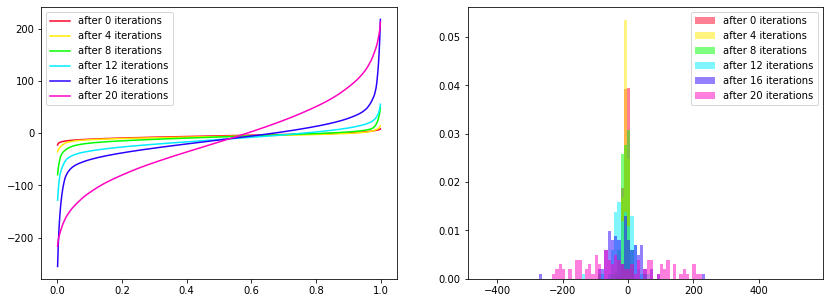

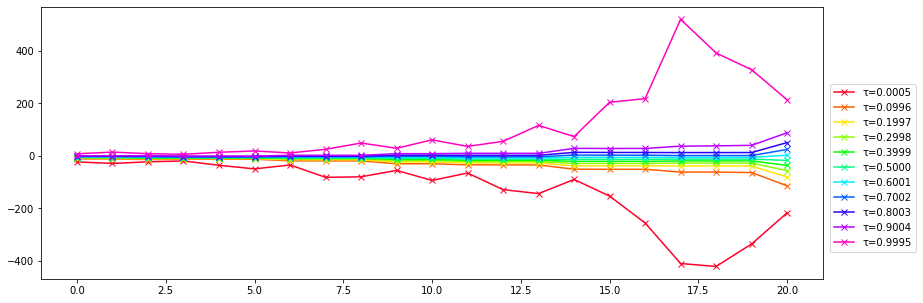

In [76]:
shift_experiment(tauspace(101), OptBasedImputer(), n_iterations=50, n_samples=101)

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     101
n iterations:  50


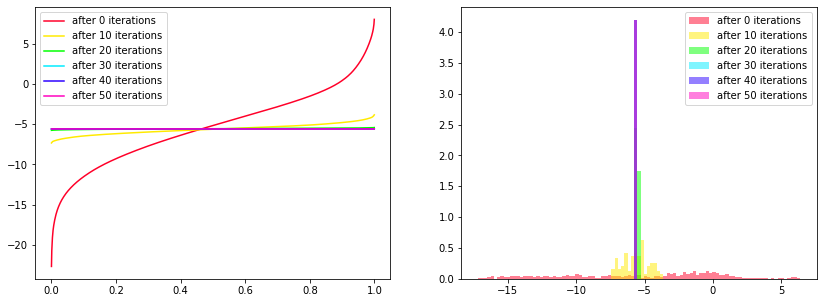

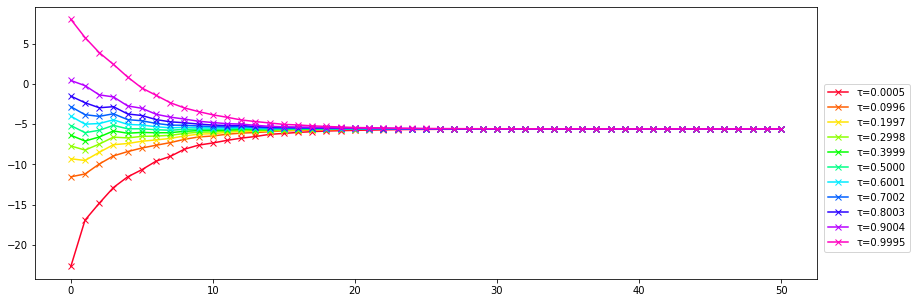

In [79]:
shift_experiment(tauspace(101), OptBasedImputer(), n_iterations=50, n_samples=101)

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  1000


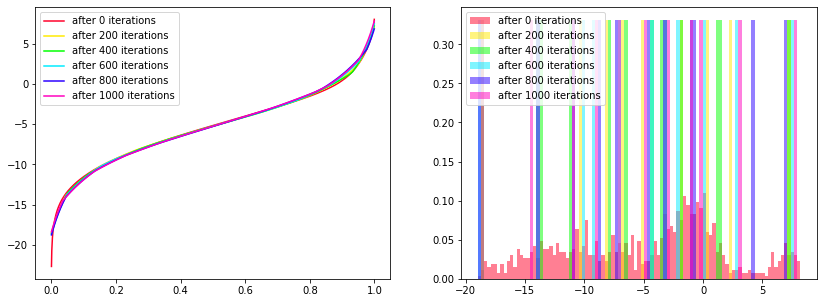

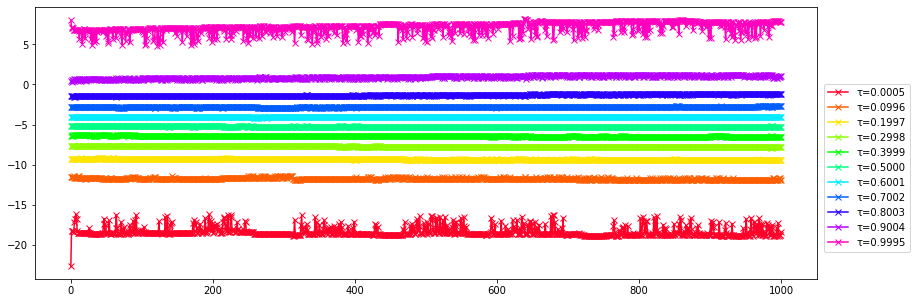

In [14]:
shift_experiment(tauspace(11), OptBasedImputer(use_lrm=False), n_iterations=1000, n_samples=11)

### 'Direct' imputer

imputation shift experiment with DirectImputer(self.smooth_invert=False, self.exp_tails=False)
n samples:     1000
n iterations:  20


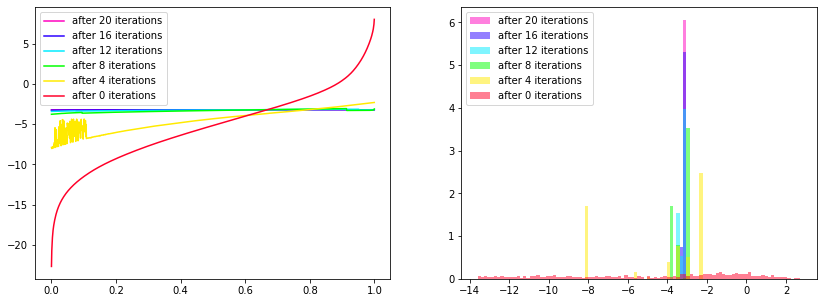

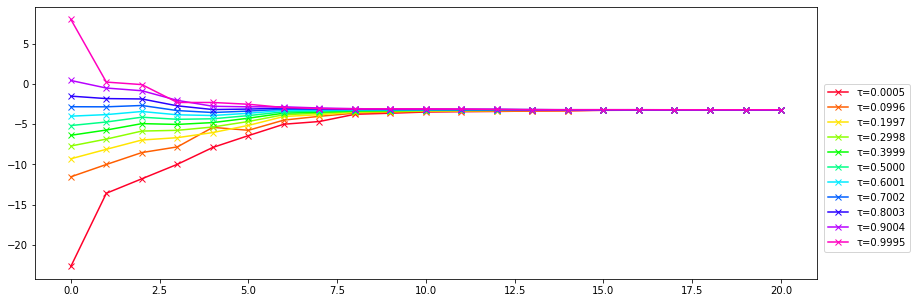

imputation shift experiment with DirectImputer(self.smooth_invert=False, self.exp_tails=False)
n samples:     1000
n iterations:  20


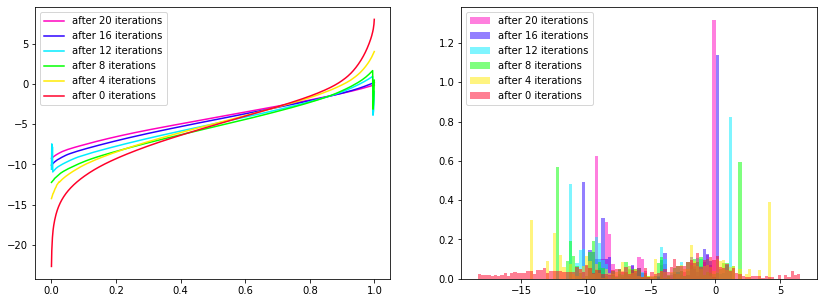

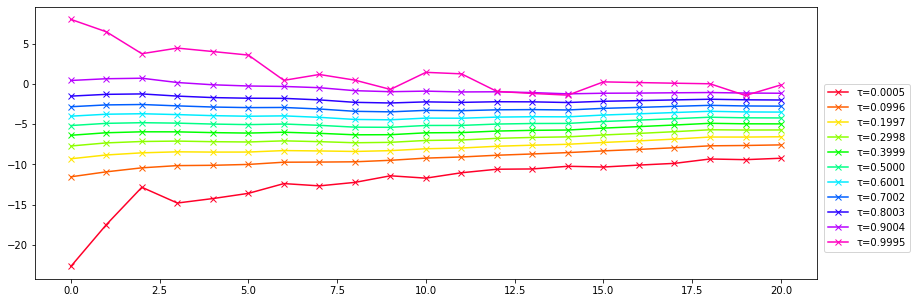

In [30]:
shift_experiment(tauspace(11), DirectImputer(), n_iterations=20)
shift_experiment(tauspace(101), DirectImputer(), n_iterations=20)

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=False)
n samples:     1000
n iterations:  20


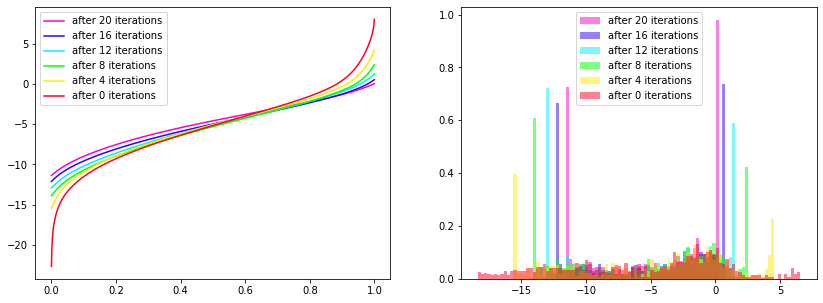

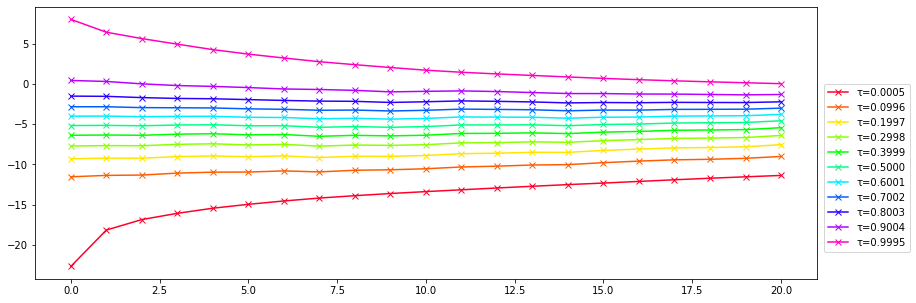

In [31]:
shift_experiment(tauspace(101), DirectImputer(smooth_invert=True), n_iterations=20)

imputation shift experiment with DirectImputer(self.smooth_invert=False, self.exp_tails=True)
n samples:     1000
n iterations:  20


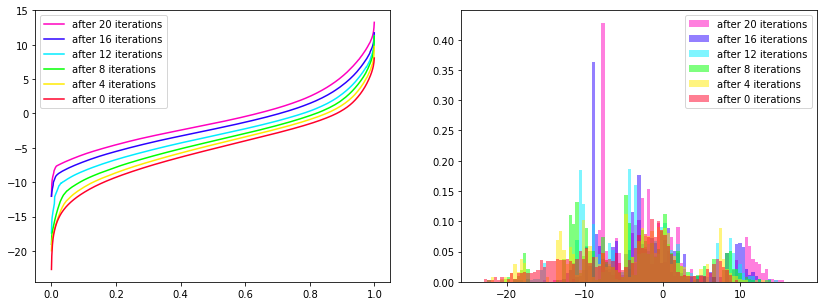

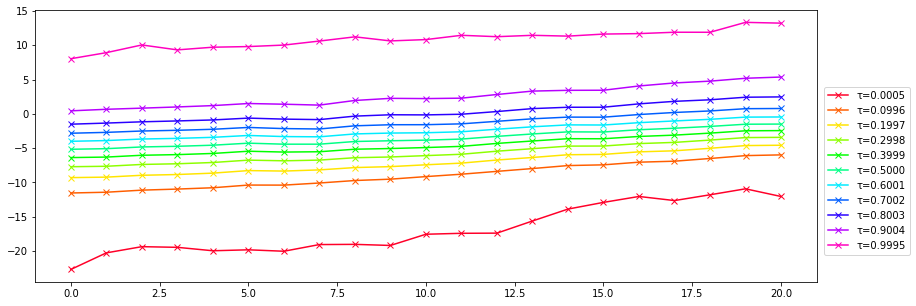

In [32]:
shift_experiment(tauspace(101), DirectImputer(exp_tails=True), n_iterations=20)

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     1000
n iterations:  20


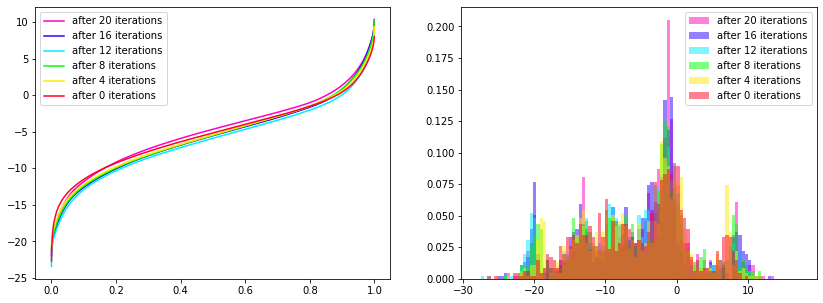

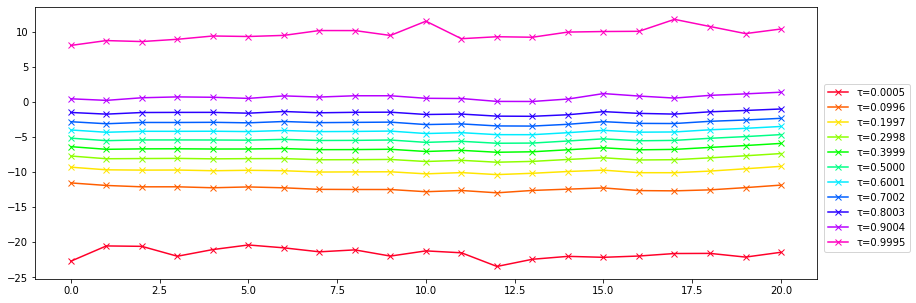

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     1000
n iterations:  1000


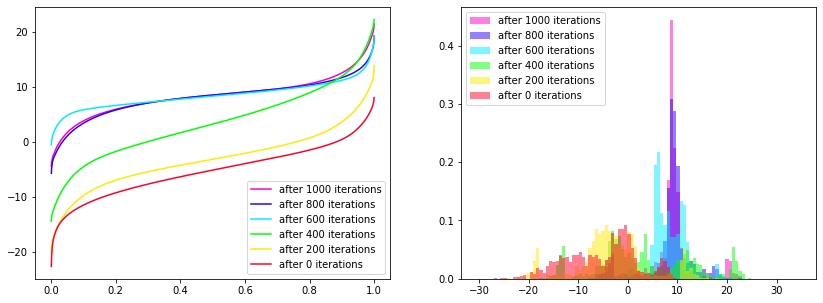

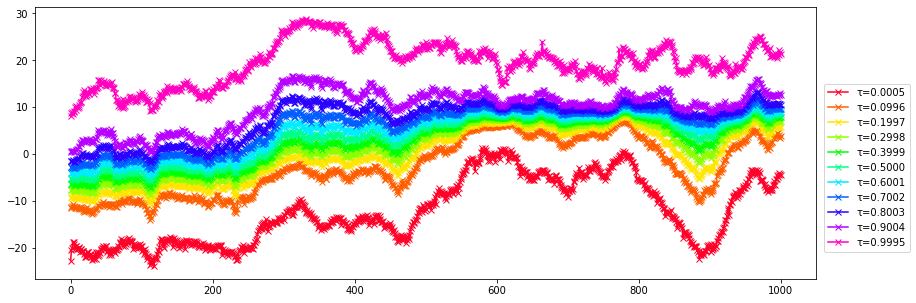

In [33]:
shift_experiment(tauspace(101), DirectImputer(smooth_invert=True, exp_tails=True), n_iterations=20)
shift_experiment(tauspace(101), DirectImputer(smooth_invert=True, exp_tails=True), n_iterations=1000)

### Direct imputer with linear interpolation and extrapolation of CDF

imputation shift experiment with InterpolatingImputer()
n samples:     1000
n iterations:  20


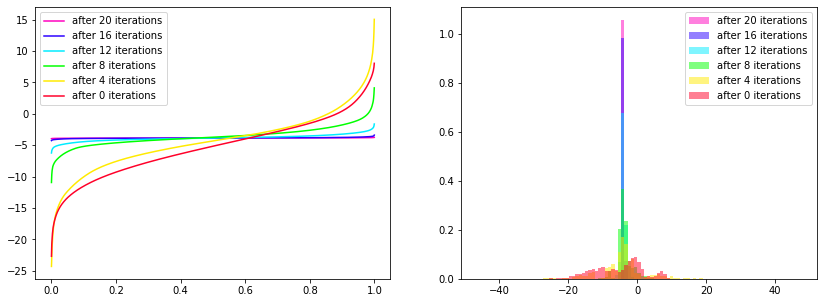

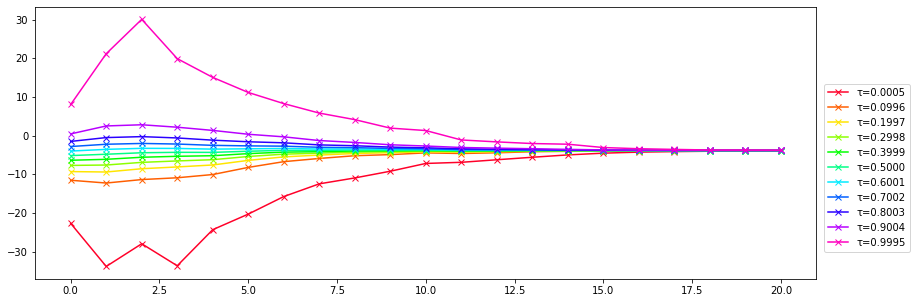

In [38]:
shift_experiment(tauspace(11), InterpolatingImputer(), n_iterations=20)

imputation shift experiment with InterpolatingImputer()
n samples:     1000
n iterations:  20


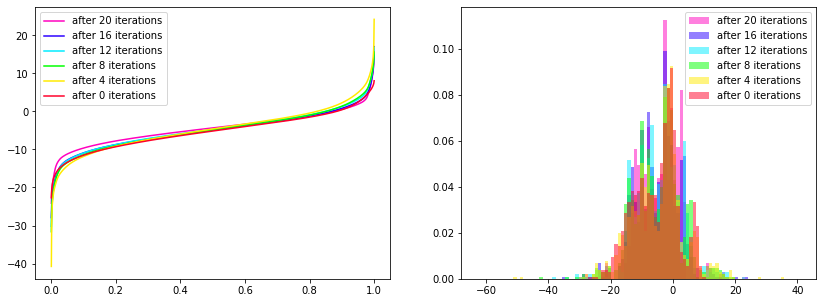

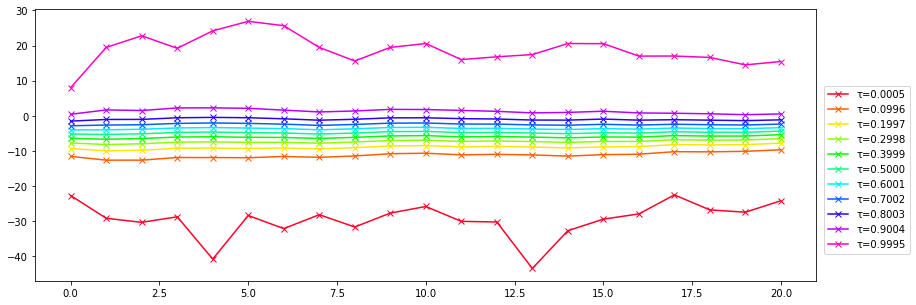

imputation shift experiment with InterpolatingImputer()
n samples:     1000
n iterations:  100


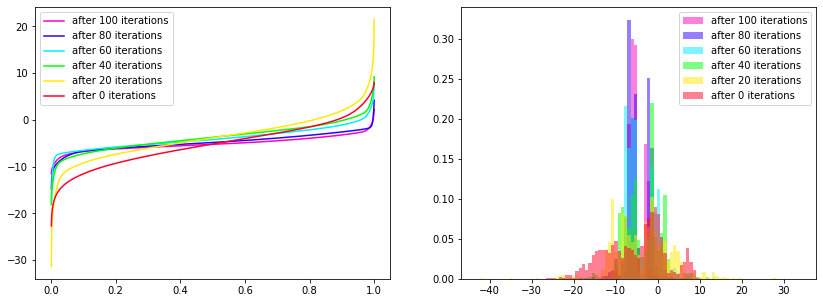

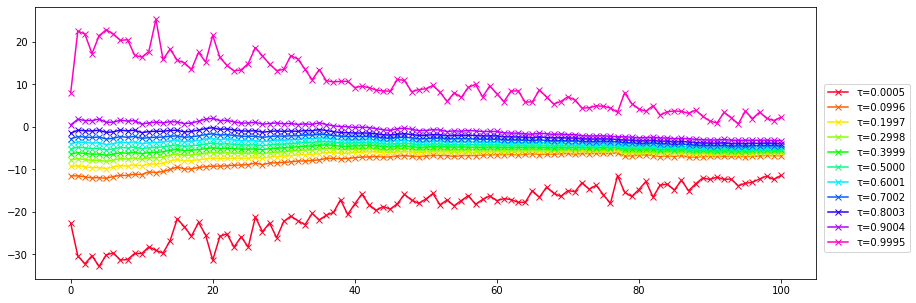

In [40]:
shift_experiment(tauspace(101), InterpolatingImputer(), n_iterations=20)
shift_experiment(tauspace(101), InterpolatingImputer(), n_iterations=100)

### Fit a logit polynomial to the expectile function

imputation shift experiment with PolyLogitImputer(d=3)
n samples:     1000
n iterations:  20


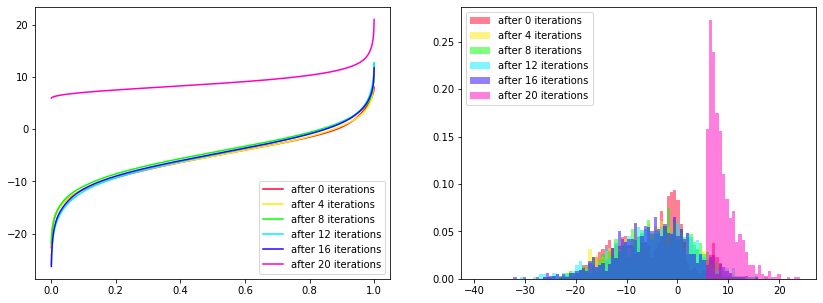

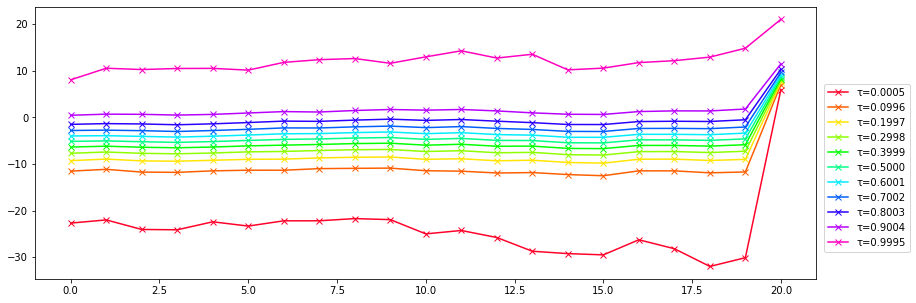

In [71]:
shift_experiment(tauspace(101), PolyLogitImputer(), n_iterations=20, n_samples=1000)

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     1000
n iterations:  100


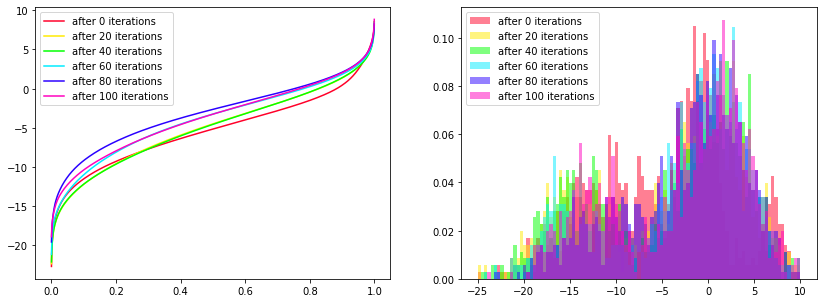

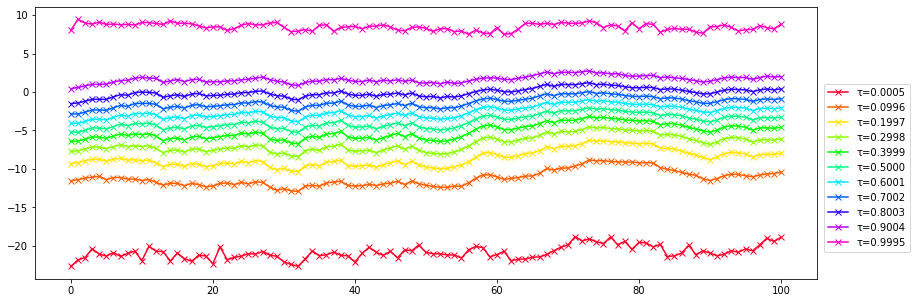

In [80]:
shift_experiment(tauspace(101), PolyLogitInterpImputer(), n_iterations=100)

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     1000
n iterations:  1000


/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.8/site

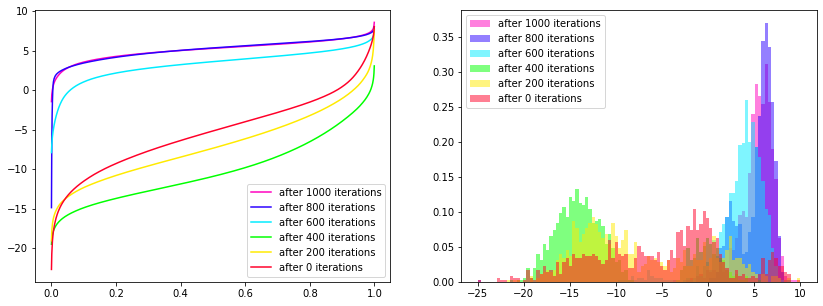

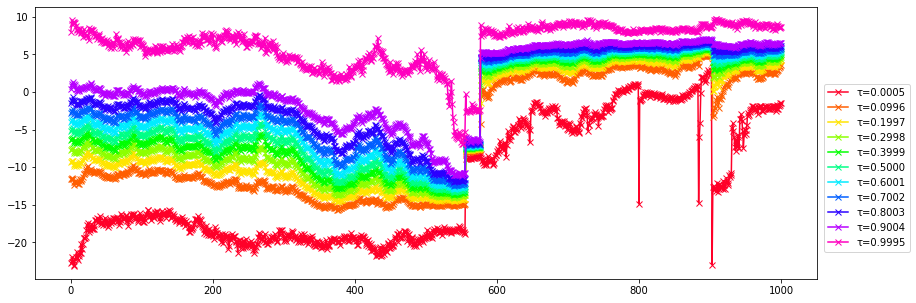

In [42]:
shift_experiment(tauspace(101), PolyLogitInterpImputer(), n_iterations=1000)

## Shift experiments without full taus

In [43]:
def positive_shift_experiment(k, imputer, **kwargs):
    shift_experiment(tauspace(k)[k//2:], imputer, i=0, **kwargs)
def negative_shift_experiment(k, imputer, **kwargs):
    shift_experiment(tauspace(k)[:k//2+1], imputer, i=k//2, **kwargs)

imputation shift experiment with InterpolatingImputer()
n samples:     1000
n iterations:  100


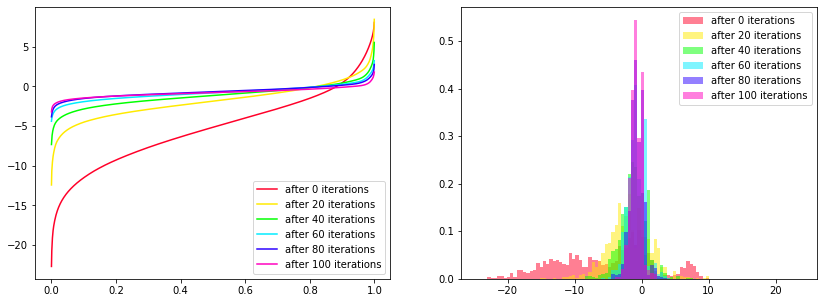

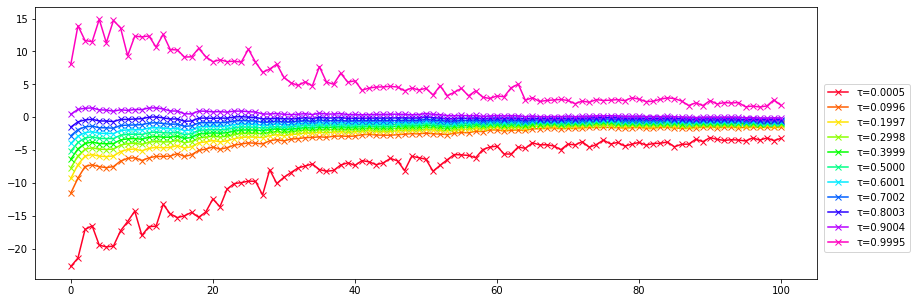

imputation shift experiment with InterpolatingImputer()
n samples:     1000
n iterations:  100


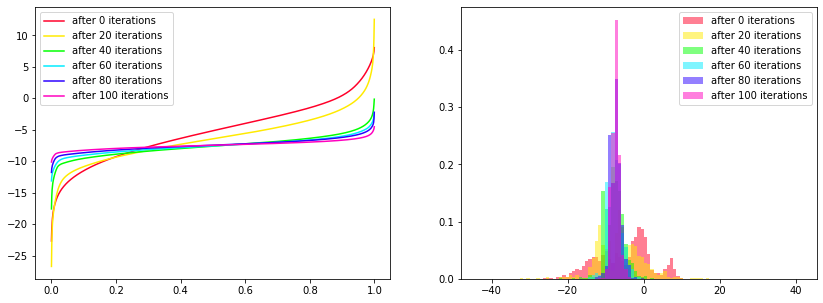

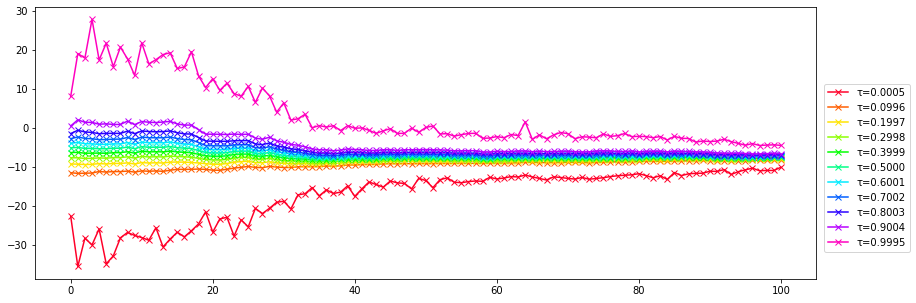

In [84]:
positive_shift_experiment(101, InterpolatingImputer())
negative_shift_experiment(101, InterpolatingImputer())

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     1000
n iterations:  100


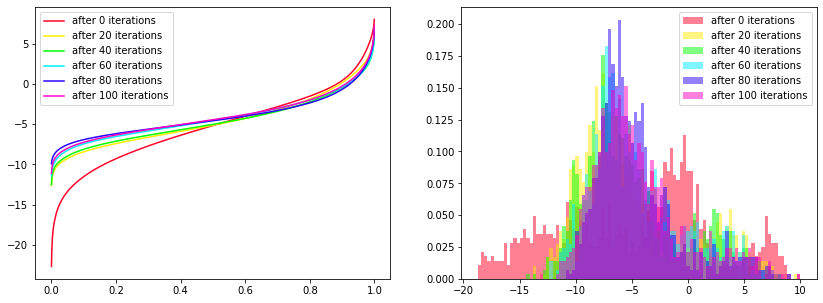

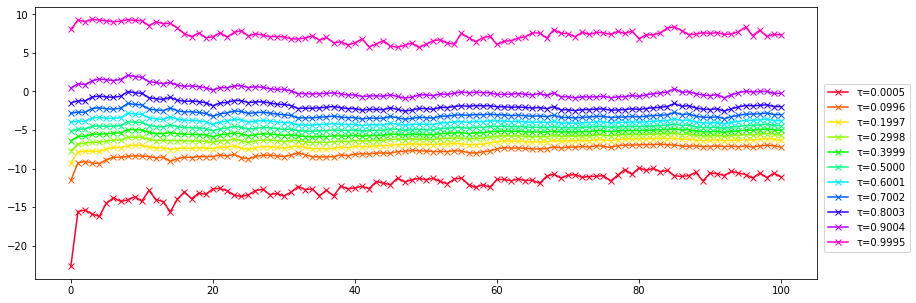

In [91]:
positive_shift_experiment(101, PolyLogitInterpImputer())

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     1000
n iterations:  20


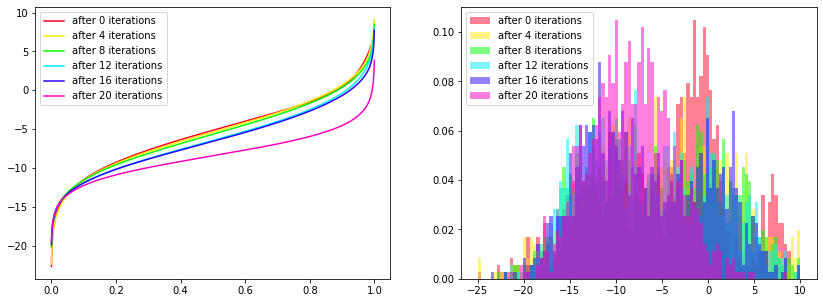

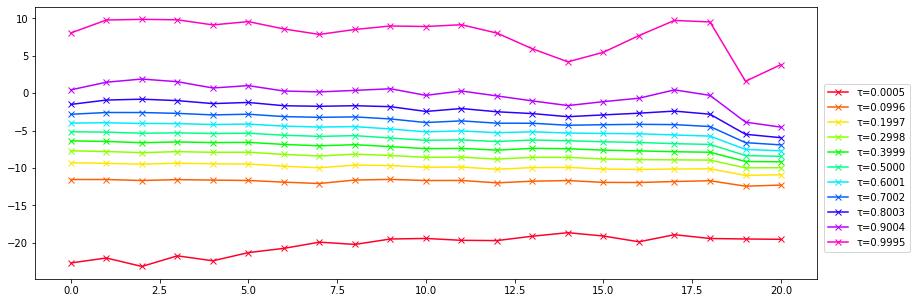

In [94]:
negative_shift_experiment(101, PolyLogitInterpImputer(), n_iterations=20)

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     1000
n iterations:  2


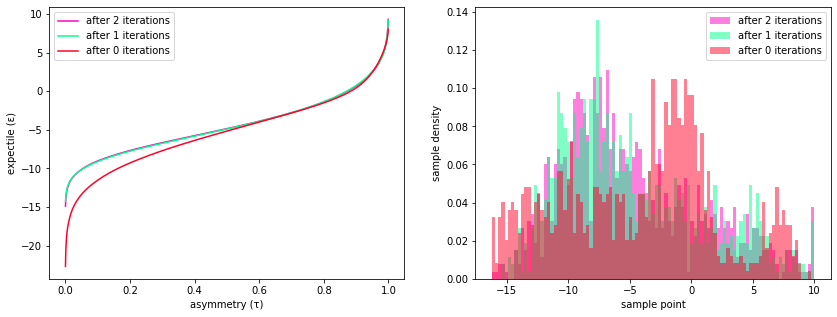

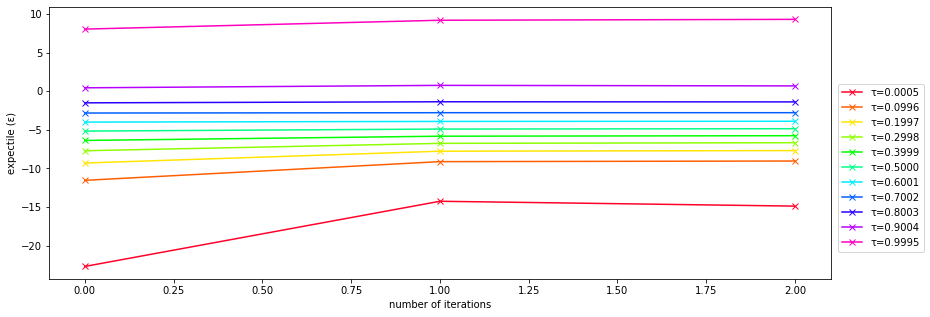

In [50]:
positive_shift_experiment(101, PolyLogitInterpImputer(), n_iterations=2)